


# MAIS 202 Final Project 


# Import libraries

In [ ]:
!pip install biopython

     |████████████████████████████████| 2.3MB 7.2MB/s 


In [ ]:
from google.colab import files
import Bio
from Bio import SeqIO
from sklearn import cluster, neighbors, decomposition
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import re, ast
import math
from datetime import datetime
import pickle
import random
import math

import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, Callback
from keras.layers import Layer
import keras.backend as K

import h5py

In [ ]:
# Import data
# file_name should be the location of the spike protein sequences in the form of a FASTA file. Sequences for this project were downloaded from GISAID.
data = list(SeqIO.parse(filename, "fasta"))

# Visualize original Wuhan virus
wuhan_original = data[0]
print(wuhan_original)

ID: Spike|hCoV-19/Wuhan/WIV04/2019|2019-12-30|EPI_ISL_402124|Original|hCoV-19^^Hubei|Human|Wuhan
Name: Spike|hCoV-19/Wuhan/WIV04/2019|2019-12-30|EPI_ISL_402124|Original|hCoV-19^^Hubei|Human|Wuhan
Description: Spike|hCoV-19/Wuhan/WIV04/2019|2019-12-30|EPI_ISL_402124|Original|hCoV-19^^Hubei|Human|Wuhan Jinyintan Hospital|Wuhan Institute of Virology|Wuhan Institute of Virology|China
Number of features: 0
Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...YT*')


#**Preprocessing Part 1**


*   Clean sequences and remove incomplete amino acid sequences. For reference, the full spike glycoprotein sequence is 1273 amino acids long.
*   Order sequences by date
*   Select geographic location of the sequences (this was not done in my model, but may be of interest to investigate)





In [ ]:
def clean_sequence(fasta_list, target_length):
  # Ignore sequences with "X", ignore duplicate IDs
  # Contains the option to write sequences to file
  sequences = {}
  for seq_record in fasta_list:
    id = seq_record.id
    str_seq = str(seq_record.seq)
    sequence = str_seq.replace("*", "")
    if (len(sequence) == target_length) and (sequence.count("X") == 0):
      if id not in sequences:
          sequences[id] = sequence
 
  with open(filename, "w+") as output_file:
    for id in sequences:
      output_file.write(">" + id + "\n" + sequences[id] + "\n")


def select_location(fasta_list, geo_location):
  # Select a particular geographic location of interest
  # Contains the option to write sequences to file
  sequences = {}
  checker = "Spike|hCoV-19/" + geo_location + "/"
  for seq_record in fasta_list:
    id = str(seq_record.id)
    sequence = str(seq_record.seq)
    if checker in id:
      sequences[id] = sequence
  
  with open(filename, "w+") as output_file:
    for id in sequences:
      output_file.write(">" + id + "\n" + sequences[id] + "\n")

def all_data(fasta_list):
  # Selecting all sequences (global)
  sequences = {}
  for seq_record in fasta_list:
    id = str(seq_record.id)
    sequence = str(seq_record.seq)
    sequences[id] = sequence
  
  with open(filename, "w+") as output_file:
    for id in sequences:
      output_file.write(">" + id + "\n" + sequences[id] + "\n")

def sort_by_date(fasta_list):
  sequences = {}
  date_id = []
  sorted = []
  for seq_record in fasta_list:
    id = str(seq_record.id)
    sequence = str(seq_record.seq)
    sequences[id] = sequence   # Define hash table
    match = re.search(r'\d{4}-\d{2}-\d{2}', id)
    if match:
      if match.group()[-2:] != "00":
        date = datetime.strptime(match.group(), '%Y-%m-%d')
        date_id.append((id, date))
  
  date_id.sort(key=lambda x:x[1]) 

  for date_id_tuple in date_id:
    id = date_id_tuple[0]
    sequence = sequences[id]
    sorted.append((id, sequence))

  with open("/content/drive/My Drive/mais_data/November 24/ordered.fasta", "w+") as output_file:
    for id_seq in sorted:
        output_file.write(">" + id_seq[0] + "\n" + id_seq[1] + "\n")

In [ ]:
# Apply processing functions
clean_sequence(data, 1273)
# select_location(data1, "USA")
all_data(data1)
sort_by_date(data2)

# Assign cleaned data to files
data1 = list(SeqIO.parse(filename, "fasta"))
data2 = list(SeqIO.parse(filename, "fasta"))
data3 = list(SeqIO.parse(filename, "fasta"))

# **Preprocessing Part 2**



*   Split data into sublists, where each sublist contains the sequences obtained from a single month
*   Encode full sequences or single site locations categorically, depending on the type of mutation prediction wanted



In [ ]:
# Split sequences by month into a list

def sort_by_month(seq_list):
  split_months = []
  for i in range(12):
    month_list = []
    if i == 0:  # Account for December 2019
      month_to_search = 12
    else:
      month_to_search = i
    for sequence in seq_list:
      id = str(sequence.id)
      match = re.search(r'\d{4}-\d{2}-\d{2}', id)
      date = datetime.strptime(match.group(), '%Y-%m-%d')
      if date.month == month_to_search:
        month_list.append(sequence)
    split_months.append(month_list)

  return split_months

def encode_seq(seq_by_month):
  # Encode all sequences sites for full sequence mutation prediction
  amino_acids = ['A', 'F', 'Q', 'R', 'T', 'Y', 'V', 'I', 'H', 'K', 'P', 'N',
                 'E', 'G', 'S', 'M', 'D', 'W', 'C', 'L', 'B', 'J', 'Z']
  le = preprocessing.LabelEncoder()  # Encodes in alphabetical order
  le.fit(amino_acids)

  encoded_seqs = []
  for month_seqs in seq_by_month:
    month_encoded_seqs = []
    for sequence in month_seqs:
      AA_chars = list(str(sequence.seq))
      month_encoded_seqs.append(le.transform(AA_chars))

    encoded_seqs.append(month_encoded_seqs)

  return encoded_seqs

def encode_seq_site(seq_by_month, site_position):
  # Encode particular sequence site for single site mutation prediction
  amino_acids = ['A', 'F', 'Q', 'R', 'T', 'Y', 'V', 'I', 'H', 'K', 'P', 'N',
                 'E', 'G', 'S', 'M', 'D', 'W', 'C', 'L', 'B', 'J', 'Z']
  le = preprocessing.LabelEncoder()  # Encodes in alphabetical order
  le.fit(amino_acids)

  encoded_seqs = []
  for month_seqs in seq_by_month:
    month_encoded_seqs = []
    for sequence in month_seqs:
      AA_char = list(str(sequence.seq)[site_position])
      month_encoded_seqs.append(le.transform(AA_char))

    encoded_seqs.append(month_encoded_seqs)

  return encoded_seqs

In [ ]:
# Temporally ordered lists by index (dec = 0, jan = 1, etc.)
seq_by_month = sort_by_month(data3)

# All encoded sequences
encoded_sequences = encode_seq(seq_by_month)

# Site 221 encodings 
encoded_221 = encode_seq_site(seq_by_month, 221)

## **Preprocessing Part 3**

Embed each amino acid sequence, whether full sequence or single site, into an n-dimensional vector representation. Single site embedding is illustrated in my poster.


1.   Split each AA sequence into 3-grams (with overlap, as depicted below).

2.   Embed each 3-gram as a 100 dimensional vector representation using pretrained embeddings.

3.   Sum all of these 3-gram vectors to produce the AA sequence embedding. By vector addition, the AA sequence embedding is also a 100 dimensional vector. 

The data source used for the embeddings is referenced in my Github.




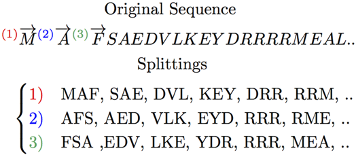


In [ ]:
def setup_embeds(file_path):
  # Import embeddings CSV and create embeddings dictionary
  with open(file_path) as csv_file:
    csv_reader = csv.reader(csv_file)
    next(csv_reader)
    embeddings = {}
    for row in csv_reader:
      temp = (row[0].split('\t'))
      nums = temp[1:]
      nums = np.array([float(num) for num in nums])
      nums = nums.reshape((100, 1))
      embeddings[temp[0]] = nums
  return embeddings


embed_dict = setup_embeds("/content/drive/My Drive/mais_data/protVec_100d_3grams.csv")


# Create 3-gram splittings with overlap
def split_seq(sequence):
  # Take as input a sequence string and output splits as list 
  split_list = [] 
  for i in range(3):
    for j in range(0, len(sequence), 3):
      if j+i+3 <= len(sequence):
        split_list.append(sequence[j+i:j+i+3])
      # if len(sequence) - j < 3:
      #   split_list.append("end")
  return split_list


def embed(sequence, embed_dict):
  # Embed an entire protein
  sequence_vec = np.zeros((100, 1))
  split_list = split_seq(sequence)
  for three_gram in split_list:
    vec_three_gram = embed_dict[three_gram]
    sequence_vec = sequence_vec + vec_three_gram
  return sequence_vec


def embed_site(sequence, site_position, embed_dict):
  # Create 3 3-gram embeddings for a specific target site on the sequence and perform summation
  site_vec = np.zeros((100, 1))
  three_grams = []
  for i in range(3):
    begin = site_position+i-2
    end = site_position+i
    three_gram = sequence[begin:end+1]
    three_grams.append(three_gram)
  for three_gram in three_grams:
    vec_three_gram = embed_dict[three_gram]
    site_vec += vec_three_gram
  return site_vec
    

def embed_all_sites(sequence_list, site_positions):
  # Expects seq_by_month variable, embeds all target sites
  all_embedded = []
  for site_position in site_positions:
    embedded_months = []
    for month in sequence_list:
      month_embed = []
      for sequence in month:
        embedded_site = embed_site(str(sequence.seq), site_position, embed_dict)
        month_embed.append(embedded_site)
      embedded_months.append(month_embed)
    all_embedded.append(embedded_months)
  return all_embedded
      

def embed_seq_by_month(sequence_list):
  # Expects seq_by_month variable, embeds all sequences
  embedded_all = []
  for month in sequence_list:
    embedded_month = []
    for sequence in month:
      embedded_month.append(embed(sequence.seq, embed_dict))
    embedded_all.append(embedded_month)
  return embedded_all


def embed_all(fasta_list, file_path):
  # Embed all proteins in FASTA file and export as CSV
  # Not ordered by month
  sequence_vecs = {}
  for seq_record in fasta_list:
    sequence = str(seq_record.seq)
    id = seq_record.id
    sequence_vec = embed(sequence, embed_dict)
    sequence_vecs[id] = sequence_vec

  with open(file_path, "w") as csv_file:
    writer = csv.writer(csv_file)
    for key, value in sequence_vecs.items():
      writer.writerow([key, value])

  return sequence_vecs

In [ ]:
embedded_all = embed_seq_by_month(seq_by_month) # Length of embedded_all should be 12
embedded_221 = embed_all_sites(seq_by_month, [221])
data_vecs = embed_all(data3, filename)

In [ ]:
# Dump the variables to save time 
with open(filename, 'wb') as filehandle:
  pickle.dump(seq_by_month, filehandle)

with open(filename, 'wb') as filehandle:
  pickle.dump(encoded_sequences, filehandle)

with open(filename, 'wb') as filehandle:
  pickle.dump(embedded_all, filehandle)

In [ ]:
with open(filename, 'rb') as filehandle:
  seq_by_month = pickle.load(filehandle)

with open(filename, 'rb') as filehandle:
  encoded_sequences = pickle.load(filehandle)

with open(filename, 'rb') as filehandle:
  embedded_all = pickle.load(filehandle)

12
12


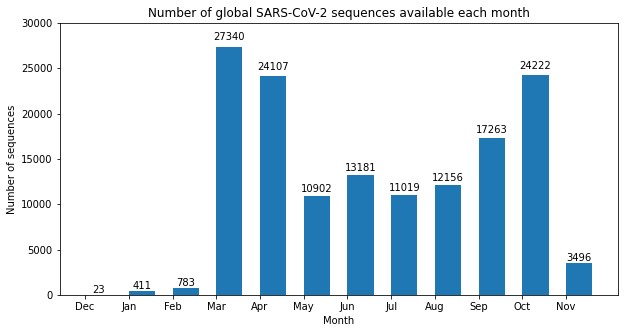

In [ ]:
# Examining data distribution

dates = []
counter = 0 
for key in data_vecs:
  id = str(key)
  match = re.search(r'\d{4}-\d{2}-\d{2}', id)
  date = datetime.strptime(match.group(), '%Y-%m-%d')
  dates.append(date)

months = [date.month for date in dates]
tests = [date for date in dates if date.month == 11]
frequencies = Counter(months)

# x = [i+1 for i in range(12)]
x = ["Dec", "Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov"]
y = [frequencies[month] for month in frequencies]

plt.figure(figsize=(10, 5))
bar_plot = plt.bar(x, y, align='edge', width=0.6)
axes = plt.gca()
axes.set_ylim([0, 30000])
plt.xlabel('Month')
plt.ylabel('Number of sequences')
plt.title('Number of global SARS-CoV-2 sequences available each month')

for idx, rect in enumerate(bar_plot):
  height = rect.get_height()
  plt.text(rect.get_x() + rect.get_width()/2., 1.02 * height,
          y[idx],
          ha='center', va='bottom', rotation=0)


# Part 4

Make the training and test datasets by randomly selecting sequences from each month and link to create a single sample for training. The last and penultimate sequence in the linked sample will be compared to create mutation y labels. 

In [ ]:
def link_train(embedded, encoded, num_samples):
  # Link December to September, predict October
  # Expecting a list of sublists, where each sublist is the ProtVec sequences in a particular month
  # Link embedded_all at the same time as encoded
  samples_emb = []
  samples_enc = []
  for i in range(num_samples):
    month_enc_samples = []  # One linked list sample
    month_emb_samples = []
    for j in range(len(embedded) - 1): # len(embedded) = len(encoded) = num months
      num_seq = len(embedded[j]) # equivalent here too
      rand_int = random.randint(0, num_seq-1) # inclusive, so subtract 1
      month_enc_samples.append(encoded[j][rand_int])
      month_emb_samples.append(embedded[j][rand_int])
    samples_emb.append(month_emb_samples)
    samples_enc.append(month_enc_samples)
  return samples_emb, samples_enc

def link_test(embedded, encoded, num_samples):
  # Link January to October, predict November
  # Expecting a list of sublists, where each sublist is the ProtVec sequences in a particular month
  # Link embedded at the same time as encoded
  samples_emb = []
  samples_enc = []
  for i in range(num_samples):
    month_enc_samples = []  # One linked list sample
    month_emb_samples = []
    for j in range(1, len(embedded)): # len(embedded) = len(encoded)
      num_seq = len(embedded[j]) # equivalent here too
      rand_int = random.randint(0, num_seq-1) # inclusive, so subtract 1
      month_enc_samples.append(encoded[j][rand_int])
      month_emb_samples.append(embedded[j][rand_int])
    samples_emb.append(month_emb_samples)
    samples_enc.append(month_enc_samples)
  return samples_emb, samples_enc

def separate_data(data):
  # Expect list of months with sequence data in each month
  # Hard split the data so there is no overlap when performing random sampling
  train = []
  test = []
  for month in data:
    train.append(month[0:math.floor(0.7*len(month))])
    test.append(month[math.floor(0.7*len(month)):])
  return train, test

In [ ]:
# Separated data, but not yet linked
embed_train, embed_test = separate_data(embedded_all)
encode_train, encode_test = separate_data(encoded_sequences)

In [ ]:
# Separated site data, but not yet linked
embed221_train, embed221_test = separate_data(embedded_221[0])
encode221_train, encode221_test = separate_data(encoded_221)

In [ ]:
# Linked train and test sets
train_embed, train_encode = link_train(embed_train, encode_train, 50000)
test_embed, test_encode = link_test(embed_test, encode_test, 5000)

In [ ]:
# Linked train and test sets for site 221
train221_embed, train221_encode = link_train(embed221_train, encode221_train, 100000)
test221_embed, test221_encode = link_test(embed221_test, encode221_test, 10000)

In [ ]:
# Exclude the embeddings for the last month in each linked list to make the final training dataset
X_train = []
for i in range(len(train_embed)):
  X_train.append(train_embed[i][0:-1])  # Everything except October

X_test = []
for j in range(len(test_embed)):
  X_test.append(test_embed[j][0:-1])  # Everything except November

In [ ]:
# Exclude the embeddings for the last month in each linked list to make the final training dataset - site 221
X221_train = []
for i in range(len(train221_embed)):
  X221_train.append(train221_embed[i][0:-1])  # Everything except October

X221_test = []
for j in range(len(test221_embed)):
  X221_test.append(test221_embed[j][0:-1])  # Everything except November

In [ ]:
X_train = np.array(X_train).reshape(50000, 10, 100)
X_test = np.array(X_test).reshape(5000, 10, 100)

In [ ]:
X221_train = np.array(X221_train).reshape(100000, 10, 100)
X221_test = np.array(X221_test).reshape(10000, 10, 100)

In [ ]:
print(X221_train.shape)  # (number of samples, time steps, features/dimension of ProtVec)

(100000, 10, 100)


In [ ]:
# Make labels by comparing penultimate with last sequences
# Requires linked categorical dataset

def make_labels(linked_enc):
  # Returns list of numpy arrays that contains categorical labels for mutations at specific sites
  y = []
  for i in range(len(linked_enc)):
    labels = np.zeros(1273)
    last = linked_enc[i][10]
    penultimate = linked_enc[i][9]
    for j in range(len(last)):
      if last[j] != penultimate[j]:
        labels[j] = 1
    y.append(labels)
  return y

def make_site_labels(linked_enc):
# Returns list of numpy arrays that contains categorical labels for mutations at one specific site
  y = []
  for i in range(len(linked_enc)):
    label = 0
    last = linked_enc[i][10]
    penultimate = linked_enc[i][9]
    if last != penultimate:
      label += 1
    y.append(label)
  return y

In [ ]:
y_train = make_labels(train_encode)  # Same order as embedded_samples
y_test = make_labels(test_encode)

In [ ]:
y221_train = make_site_labels(train221_encode)  # Same order as embedded_samples
y221_test = make_site_labels(test221_encode)

In [ ]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
y221_train = np.array(y221_train)
y221_test = np.array(y221_test)

In [ ]:
print(np.count_nonzero(y221_train==0))
print(np.count_nonzero(y221_train==1))
# Pretty even distribution of the number of times mutation 221 appears.

23995
26005


In [ ]:
# Some useful code for understanding the data
# Finding the item in the list which produced the max mutations 
train_sum = np.sum(y_train, axis=1)
max_ind = np.argmax(train_sum)  # argmin, sometimes there is no mutations too
most_mutations = train_sum[max_ind]
print(most_mutations)

# Finding the average number of mutations for the training data
average_mutations = np.sum(train_sum)/len(y_train)
print(average_mutations)

# Find the mutation distribution of the data 
mutation_vec = np.zeros(1273)
no_mutations = 0

for i in range(50000):
  label = y_train[i]
  if np.sum(label) == 0:
    no_mutations += 1
  else:
    for j in range(len(label)):
      if label[j] == 1:
        mutation_vec[j] += 1
      else:
        continue

mutation_221 = 0
for i in range(300000):
  label = y_train[i]
  if label[221] == 1 and np.sum(label) == 1:
    mutation_221 += 1

mutation_221_3 = 0
for i in range(300000):
  label = y_train[i]
  if label[221] == 1 and np.sum(label) == 3:
    mutation_221_3 += 1

Text(0.5, 1.0, 'Mutation frequency for sequence sites between September and October')

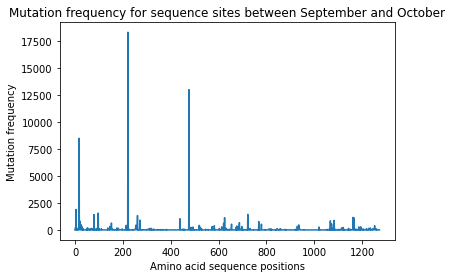

In [ ]:
plt.plot(mutation_vec)
plt.xlabel('Amino acid sequence positions')
plt.ylabel('Mutation frequency')
plt.title('Mutation frequency for sequence sites between September and October')

In [ ]:
print(y_train.shape)  # (number of samples, dimension of labels)

(50000, 1273)


In [ ]:
# Useful sanity checks
# print(test_encode[0][8][0])
# print(test_encode[0][9][0])
test1 = test_encode[0][8]
test2 = test_encode[0][9]

labels = np.zeros(1273)

for i in range(len(test1)):
  if test1[i] != test2[i]:
    print((test1[i], test2[i], i))
    labels[i] = 1

print(np.where(labels == 1))

# Part 5

Model construction and training the following models can be used for both the specific site mutation prediction as well as the full sequence mutation prediction. 

In [ ]:
pip install keras-self-attention

In [ ]:
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                 patience=3,
                                 verbose=1,
                                 factor=0.5,
                                 min_lr=0.000001)

In [ ]:
class attention(Layer):
    def __init__(self, units, output_dim):
      self.units = units
      self.output_dim = output_dim

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
]

model = keras.Sequential()
model.add(layers.LSTM(units=128, return_sequences=True, input_shape=(X221_train.shape[1], X221_train.shape[2])))
# model.add(layers.LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))  # Use this line instead of the previous if doing full sequence prediction
model.add(layers.LSTM(units=128))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))  # Change units to 1273 in the fully connected layer if doing full sequence prediction
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=[METRICS, 'accuracy'])

# Checkpointing
filepath="weights-improvement-trial-randomstate_7.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')
callbacks_list = [checkpoint]
callbacks_list += [lr_reduction]


# An attention model I was playing with, but this is not supported with the code I have written

# model = keras.Sequential()

# model.add(layers.LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(layers.LSTM(units=128, return_sequences=True))
# model.add(SeqWeightedAttention())
# model.add(Dropout(0.2))
# model.add(Dense(units=1273,activation='sigmoid'))
# model.summary()

# model.add(Dropout(0.2))
# model.add(keras.layers.Dense(units=1273))

In [ ]:
history = model.fit(
    X221_train, y221_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    shuffle=False,
    callbacks=callbacks_list
    )

Epoch 1/50
2499/2500 [============================>.] - ETA: 0s - loss: 6.1431e-08 - tp: 14847.0000 - fp: 13773.0000 - tn: 24986.0000 - fn: 26362.0000 - precision: 0.5188 - recall: 0.3603 - accuracy: 0.4981
Epoch 00001: val_accuracy improved from -inf to 0.47995, saving model to weights-improvement-trial-randomstate_7.hdf5
2500/2500 [==============================] - 85s 34ms/step - loss: 6.1426e-08 - tp: 14849.0000 - fp: 13778.0000 - tn: 25000.0000 - fn: 26373.0000 - precision: 0.5187 - recall: 0.3602 - accuracy: 0.4981 - val_loss: 6.2001e-08 - val_tp: 1.0000 - val_fp: 0.0000e+00 - val_tn: 9598.0000 - val_fn: 10401.0000 - val_precision: 1.0000 - val_recall: 9.6135e-05 - val_accuracy: 0.4800
Epoch 2/50
2499/2500 [============================>.] - ETA: 0s - loss: 6.1431e-08 - tp: 15022.0000 - fp: 13857.0000 - tn: 24902.0000 - fn: 26187.0000 - precision: 0.5202 - recall: 0.3645 - accuracy: 0.4992
Epoch 00002: val_accuracy did not improve from 0.47995
2500/2500 [==========================

In [ ]:
# Testing accuracy on test data
y_pred = model.predict(X221_test)
thresh = 0.5
for i in range(len(y_pred)):
  up = y_pred[i] >= 0.5
  down = y_pred[i] < 0.5
  y_pred[i][up] = 1
  y_pred[i][down] = 0

In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y221_test, y_pred)
print(accuracy)

0.5689


[[5.686e-01 1.000e-04]
 [4.310e-01 3.000e-04]]


[Text(19.699999999999996, 0.5, 'Actual value'),
 Text(0.5, 44.24, 'Predicted value')]

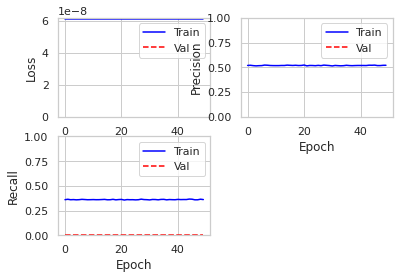

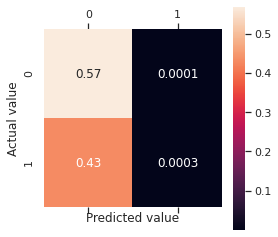

In [ ]:
def plot_metrics(history):
  metrics = ['loss', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color='blue', label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color='red', linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    else:
      plt.ylim([0,1])

    plt.legend()

plot_metrics(history)
confusionmatrix = confusion_matrix(y221_test, y_pred.reshape(10000), normalize='all')
plt.matshow(confusionmatrix)
print(confusionmatrix)

import seaborn as sns

ax = sns.heatmap(confusionmatrix, annot=True)
ax.set(xlabel="Predicted value", ylabel="Actual value")

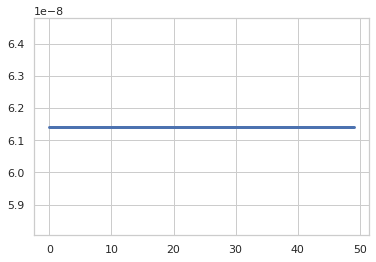

In [ ]:
sns.set_theme(style='whitegrid')
data = [history.history['loss'], history]
sns.lineplot(data=history.history["loss"], linewidth=3)

In [ ]:
# Logistic regression testing with specific site mutation prediction

lr_X_train = X221_train[:, 9, :]  # Input only last month sequence embeddings to predict next month

model_lr = keras.Sequential()
model_lr.add(Dense(1, input_shape=(100,), activation='sigmoid'))
model_lr.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['binary_accuracy'])

In [ ]:
history1=model_lr.fit(
    x=lr_X_train,
    y=y221_train,
    shuffle=False,
    epochs=15,
    batch_size=1,
    callbacks=callbacks_list
)

Epoch 1/15
50000/50000 [==============================] - 44s 884us/step - loss: 0.6932 - binary_accuracy: 0.5218
Epoch 2/15
50000/50000 [==============================] - 41s 817us/step - loss: 0.6932 - binary_accuracy: 0.5218
Epoch 3/15
50000/50000 [==============================] - 40s 806us/step - loss: 0.6932 - binary_accuracy: 0.5218
Epoch 4/15
50000/50000 [==============================] - 42s 831us/step - loss: 0.6932 - binary_accuracy: 0.5218
Epoch 5/15
50000/50000 [==============================] - 39s 775us/step - loss: 0.6932 - binary_accuracy: 0.5218
Epoch 6/15
50000/50000 [==============================] - 37s 742us/step - loss: 0.6932 - binary_accuracy: 0.5218
Epoch 7/15
50000/50000 [==============================] - 41s 824us/step - loss: 0.6932 - binary_accuracy: 0.5218
Epoch 8/15
50000/50000 [==============================] - 39s 780us/step - loss: 0.6932 - binary_accuracy: 0.5218
Epoch 9/15
50000/50000 [==============================] - 40s 790us/step - loss: 0.6932 

In [ ]:
# Naive neural network testing with specific site mutation prediction

model_nn = keras.Sequential()
model_nn.add(Dense(64, input_shape=(100,), activation='relu'))
model_nn.add(Dense(64, activation='relu'))
model_nn.add(Dense(1, activation='sigmoid'))
model_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

filepath="weights-improvement-trial-randomstate_7.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')
callbacks_list = [checkpoint]
callbacks_list += [lr_reduction]

history2=model_nn.fit(
    x=lr_X_train,  # Takes as input the same data inputted into lr_X_train
    y=y221_train,
    shuffle=True,
    epochs=15,
    batch_size=32,
    callbacks=callbacks_list
)

Epoch 1/15
1563/1563 [==============================] - 3s 2ms/step - loss: 0.6915 - binary_accuracy: 0.5306
Epoch 2/15
1563/1563 [==============================] - 3s 2ms/step - loss: 0.6914 - binary_accuracy: 0.5311
Epoch 3/15
1563/1563 [==============================] - 3s 2ms/step - loss: 0.6913 - binary_accuracy: 0.5315
Epoch 4/15
1563/1563 [==============================] - 3s 2ms/step - loss: 0.6913 - binary_accuracy: 0.5317
Epoch 5/15
1563/1563 [==============================] - 3s 2ms/step - loss: 0.6912 - binary_accuracy: 0.5317
Epoch 6/15
1563/1563 [==============================] - 3s 2ms/step - loss: 0.6914 - binary_accuracy: 0.5316
Epoch 7/15
1563/1563 [==============================] - 3s 2ms/step - loss: 0.6913 - binary_accuracy: 0.5317
Epoch 8/15
1563/1563 [==============================] - 3s 2ms/step - loss: 0.6913 - binary_accuracy: 0.5317
Epoch 9/15
1563/1563 [==============================] - 4s 3ms/step - loss: 0.6912 - binary_accuracy: 0.5316
Epoch 10/15
1563/15